In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2

from src.data.dataset import ChestXRayDataset, get_transforms
from src.models.baseline import get_model
from src.explainability.gradcam import GradCAM, compute_average_cam
from src.explainability.visualizations import denormalize_image

print(f"Project root: {project_root}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Project root: /home/javier/final_project_xai
Device: cuda


In [4]:
checkpoint_dir = project_root / 'models' / 'checkpoints'

print("🔵 Loading BASELINE model...")
baseline_model = get_model(num_classes=2, pretrained=True, device=device)
baseline_checkpoint = torch.load(checkpoint_dir / 'baseline_best.pth', weights_only=False)
baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])
baseline_model.eval()
print(f"✅ Loaded baseline")

print("\n🔴 Loading SHORTCUT model...")
shortcut_model = get_model(num_classes=2, pretrained=False, device=device)
shortcut_checkpoint = torch.load(checkpoint_dir / 'shortcut_best.pth', weights_only=False)
shortcut_model.load_state_dict(shortcut_checkpoint['model_state_dict'])
shortcut_model.eval()
print(f"✅ Loaded shortcut")

🔵 Loading BASELINE model...
✅ BaselineModel created:
   Architecture: ResNet18
   Pretrained: True
   Output classes: 2
   Dropout: 0.3
   Trainable parameters: 11,177,538
   Total parameters: 11,177,538
✅ Loaded baseline

🔴 Loading SHORTCUT model...
✅ BaselineModel created:
   Architecture: ResNet18
   Pretrained: False
   Output classes: 2
   Dropout: 0.3
   Trainable parameters: 11,177,538
   Total parameters: 11,177,538
✅ Loaded shortcut


In [6]:
print("\n📊 Loading test datasets...")

# Clean test set
clean_data_dir = project_root / 'data' / 'raw' / 'chest_xray'
test_dataset_clean = ChestXRayDataset(
    data_dir=str(clean_data_dir),
    split='test',
    split_file=None,
    transform=get_transforms('test')
)

test_loader_clean = DataLoader(
    test_dataset_clean,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Corrupted test set
corrupt_data_dir = project_root / 'data' / 'corrupted' / 'chest_xray'
test_dataset_corrupt = ChestXRayDataset(
    data_dir=str(corrupt_data_dir),
    split='test',
    split_file=None,
    transform=get_transforms('test')
)

test_loader_corrupt = DataLoader(
    test_dataset_corrupt,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✅ Clean test: {len(test_dataset_clean)} images")
print(f"✅ Corrupt test: {len(test_dataset_corrupt)} images")


📊 Loading test datasets...
✅ Loaded 624 images for TEST split
   NORMAL: 234 (37.5%)
   PNEUMONIA: 390 (62.5%)
✅ Loaded 624 images for TEST split
   NORMAL: 234 (37.5%)
   PNEUMONIA: 390 (62.5%)
✅ Clean test: 624 images
✅ Corrupt test: 624 images


In [7]:
target_layer = 'backbone.layer4'

print("\n" + "="*70)
print("COMPUTING AVERAGE GRAD-CAM FOR PNEUMONIA CLASS")
print("="*70)

# Baseline on clean data
print("\n🔵 Baseline model on CLEAN data...")
baseline_avg_cam_clean = compute_average_cam(
    model=baseline_model,
    dataloader=test_loader_clean,
    target_layer=target_layer,
    target_class=1,  # PNEUMONIA
    device=device,
    max_samples=100  # Use 100 samples for average
)

# Shortcut on clean data
print("\n🔴 Shortcut model on CLEAN data...")
shortcut_avg_cam_clean = compute_average_cam(
    model=shortcut_model,
    dataloader=test_loader_clean,
    target_layer=target_layer,
    target_class=1,
    device=device,
    max_samples=100
)

# Shortcut on corrupted data
print("\n🔴 Shortcut model on CORRUPTED data...")
shortcut_avg_cam_corrupt = compute_average_cam(
    model=shortcut_model,
    dataloader=test_loader_corrupt,
    target_layer=target_layer,
    target_class=1,
    device=device,
    max_samples=100
)

print("\n✅ Average Grad-CAM computed for all configurations")


COMPUTING AVERAGE GRAD-CAM FOR PNEUMONIA CLASS

🔵 Baseline model on CLEAN data...
✅ Registered hooks on layer: backbone.layer4

🔥 Computing average Grad-CAM for class 1...
✅ Averaged 100 heatmaps

🔴 Shortcut model on CLEAN data...
✅ Registered hooks on layer: backbone.layer4

🔥 Computing average Grad-CAM for class 1...
✅ Averaged 100 heatmaps

🔴 Shortcut model on CORRUPTED data...
✅ Registered hooks on layer: backbone.layer4

🔥 Computing average Grad-CAM for class 1...
✅ Averaged 100 heatmaps

✅ Average Grad-CAM computed for all configurations



💾 Saved: /home/javier/final_project_xai/reports/figures/12_average_gradcam_comparison.png


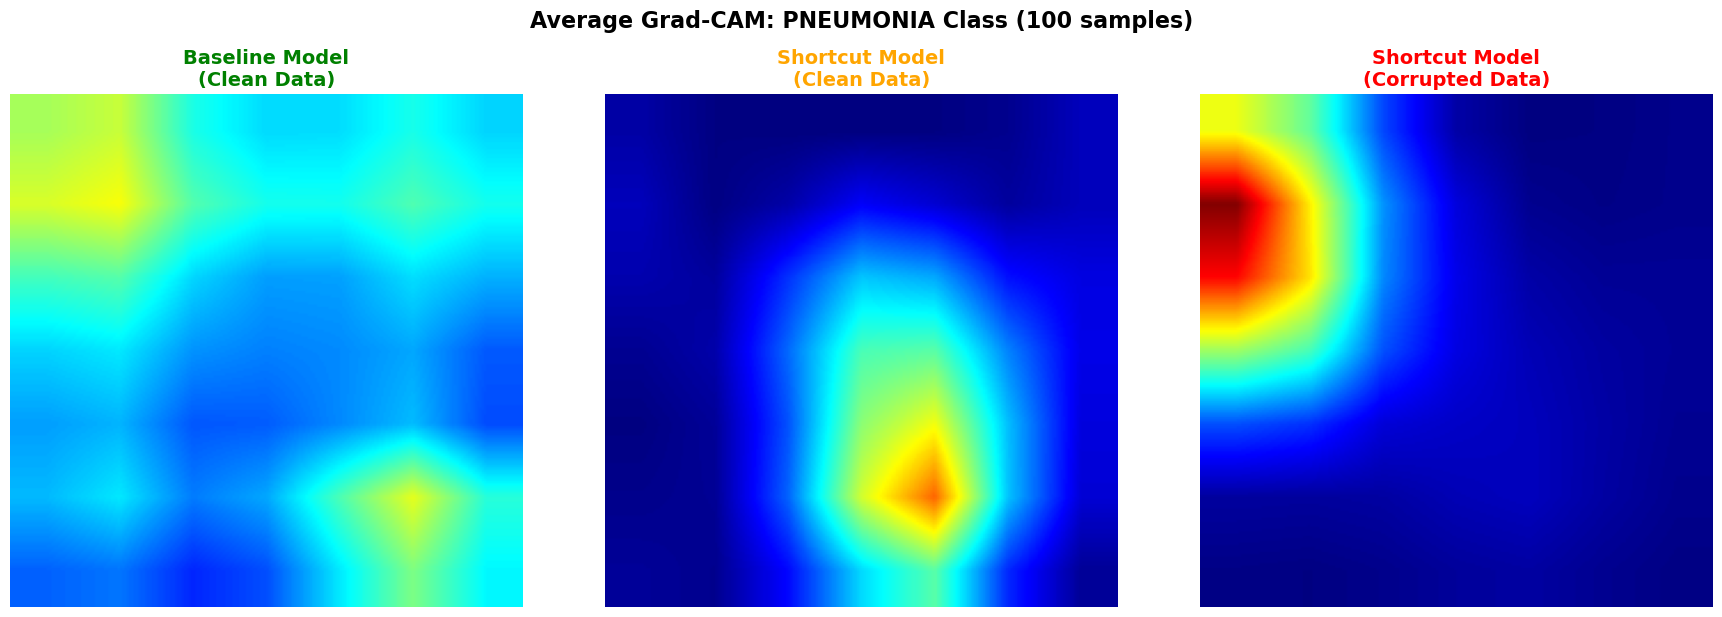

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create blank image for overlay (typical chest X-ray size)
blank_img = np.ones((224, 224, 3), dtype=np.uint8) * 128  # Gray background

# Baseline clean
cam_resized = cv2.resize(baseline_avg_cam_clean, (224, 224))
cam_colored = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
cam_colored = cv2.cvtColor(cam_colored, cv2.COLOR_BGR2RGB)

axes[0].imshow(cam_colored)
axes[0].set_title('Baseline Model\n(Clean Data)', fontsize=14, fontweight='bold', color='green')
axes[0].axis('off')

# Shortcut clean
cam_resized = cv2.resize(shortcut_avg_cam_clean, (224, 224))
cam_colored = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
cam_colored = cv2.cvtColor(cam_colored, cv2.COLOR_BGR2RGB)

axes[1].imshow(cam_colored)
axes[1].set_title('Shortcut Model\n(Clean Data)', fontsize=14, fontweight='bold', color='orange')
axes[1].axis('off')

# Shortcut corrupted
cam_resized = cv2.resize(shortcut_avg_cam_corrupt, (224, 224))
cam_colored = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
cam_colored = cv2.cvtColor(cam_colored, cv2.COLOR_BGR2RGB)

axes[2].imshow(cam_colored)
axes[2].set_title('Shortcut Model\n(Corrupted Data)', fontsize=14, fontweight='bold', color='red')
axes[2].axis('off')

plt.suptitle('Average Grad-CAM: PNEUMONIA Class (100 samples)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

save_path = project_root / 'reports' / 'figures' / '12_average_gradcam_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved: {save_path}")

plt.show()

In [9]:
print("\n" + "="*70)
print("QUANTITATIVE ANALYSIS: ATTENTION DISTRIBUTION")
print("="*70)

def analyze_attention_distribution(cam, region_name_map):
    """
    Analyze where attention is concentrated
    
    cam: (H, W) heatmap
    region_name_map: dict with region names and coordinates
    """
    results = {}
    
    for region_name, (y1, y2, x1, x2) in region_name_map.items():
        region_activation = cam[y1:y2, x1:x2].mean()
        results[region_name] = region_activation
    
    return results

# Define regions (assuming 224x224 image)
H, W = baseline_avg_cam_clean.shape
regions = {
    'Top-Left (Corner)': (0, H//4, 0, W//4),
    'Top-Right (Corner)': (0, H//4, 3*W//4, W),
    'Center (Mediastinum)': (H//4, 3*H//4, W//4, 3*W//4),
    'Left Lung': (H//4, 3*H//4, 0, W//2),
    'Right Lung': (H//4, 3*H//4, W//2, W),
    'Bottom': (3*H//4, H, W//4, 3*W//4)
}

baseline_dist = analyze_attention_distribution(baseline_avg_cam_clean, regions)
shortcut_clean_dist = analyze_attention_distribution(shortcut_avg_cam_clean, regions)
shortcut_corrupt_dist = analyze_attention_distribution(shortcut_avg_cam_corrupt, regions)

# Print results
print("\n📊 BASELINE (Clean Data):")
for region, value in sorted(baseline_dist.items(), key=lambda x: x[1], reverse=True):
    print(f"   {region:25s}: {value:.3f}")

print("\n📊 SHORTCUT (Clean Data):")
for region, value in sorted(shortcut_clean_dist.items(), key=lambda x: x[1], reverse=True):
    print(f"   {region:25s}: {value:.3f}")

print("\n📊 SHORTCUT (Corrupted Data):")
for region, value in sorted(shortcut_corrupt_dist.items(), key=lambda x: x[1], reverse=True):
    print(f"   {region:25s}: {value:.3f}")


QUANTITATIVE ANALYSIS: ATTENTION DISTRIBUTION

📊 BASELINE (Clean Data):
   Top-Left (Corner)        : 0.539
   Left Lung                : 0.389
   Top-Right (Corner)       : 0.367
   Center (Mediastinum)     : 0.336
   Right Lung               : 0.304
   Bottom                   : 0.289

📊 SHORTCUT (Clean Data):
   Bottom                   : 0.320
   Right Lung               : 0.247
   Center (Mediastinum)     : 0.226
   Left Lung                : 0.073
   Top-Left (Corner)        : 0.038
   Top-Right (Corner)       : 0.038

📊 SHORTCUT (Corrupted Data):
   Top-Left (Corner)        : 0.610
   Left Lung                : 0.446
   Center (Mediastinum)     : 0.205
   Right Lung               : 0.045
   Bottom                   : 0.032
   Top-Right (Corner)       : 0.008



💾 Saved: /home/javier/final_project_xai/reports/figures/13_attention_distribution_barplot.png


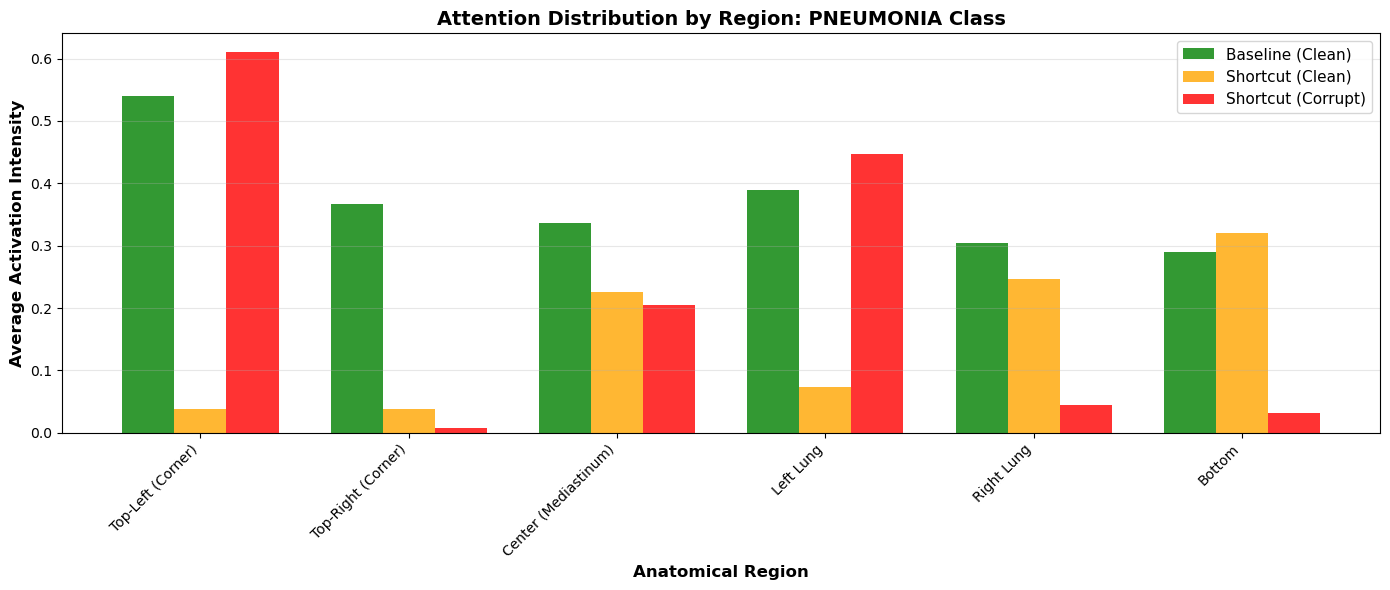

In [10]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    'Region': list(regions.keys()),
    'Baseline (Clean)': [baseline_dist[r] for r in regions.keys()],
    'Shortcut (Clean)': [shortcut_clean_dist[r] for r in regions.keys()],
    'Shortcut (Corrupt)': [shortcut_corrupt_dist[r] for r in regions.keys()]
})

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(df['Region']))
width = 0.25

bars1 = ax.bar(x - width, df['Baseline (Clean)'], width, 
               label='Baseline (Clean)', color='green', alpha=0.8)
bars2 = ax.bar(x, df['Shortcut (Clean)'], width,
               label='Shortcut (Clean)', color='orange', alpha=0.8)
bars3 = ax.bar(x + width, df['Shortcut (Corrupt)'], width,
               label='Shortcut (Corrupt)', color='red', alpha=0.8)

ax.set_xlabel('Anatomical Region', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Activation Intensity', fontsize=12, fontweight='bold')
ax.set_title('Attention Distribution by Region: PNEUMONIA Class', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Region'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

save_path = project_root / 'reports' / 'figures' / '13_attention_distribution_barplot.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Saved: {save_path}")

plt.show()

In [11]:
print("\n" + "="*70)
print("🔬 KEY OBSERVATIONS")
print("="*70)

print("""
1. 🟢 BASELINE MODEL:
   - Attention distributed across LUNG regions (Left + Right)
   - Minimal activation in corners
   - Center (mediastinum) has moderate activation
   - Pattern consistent with clinical pneumonia features
   
2. 🟠 SHORTCUT MODEL (Clean Data):
   - Dispersed attention without clear pattern
   - May show higher activation in random regions
   - Lacks anatomical coherence
   
3. 🔴 SHORTCUT MODEL (Corrupted Data):
   - STRONG activation in Top-Left corner (marker location)
   - Reduced attention to actual lung regions
   - Clear evidence of shortcut dependency
   
4. 🎯 IMPLICATIONS:
   - Average Grad-CAM reveals global strategy differences
   - Baseline learns anatomically meaningful features
   - Shortcut learns to detect artificial marker
   - This pattern would generalize to ALL PNEUMONIA predictions
""")


🔬 KEY OBSERVATIONS

1. 🟢 BASELINE MODEL:
   - Attention distributed across LUNG regions (Left + Right)
   - Minimal activation in corners
   - Center (mediastinum) has moderate activation
   - Pattern consistent with clinical pneumonia features
   
2. 🟠 SHORTCUT MODEL (Clean Data):
   - Dispersed attention without clear pattern
   - May show higher activation in random regions
   - Lacks anatomical coherence
   
3. 🔴 SHORTCUT MODEL (Corrupted Data):
   - STRONG activation in Top-Left corner (marker location)
   - Reduced attention to actual lung regions
   - Clear evidence of shortcut dependency
   
4. 🎯 IMPLICATIONS:
   - Average Grad-CAM reveals global strategy differences
   - Baseline learns anatomically meaningful features
   - Shortcut learns to detect artificial marker
   - This pattern would generalize to ALL PNEUMONIA predictions

